In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression

In [18]:
df_train = pd.read_excel(r"df_retrain/datos_train.xlsx")
df_val = pd.read_excel(r"df_retrain/datos_val.xlsx")
df_test = pd.read_excel(r"df_retrain/datos_test.xlsx")

In [19]:
#La parte de creación de datos sinteticos correrla una única vez para generar el dataframe de pruebas. Luego guardar en xlsx para su recuperación
from pathlib import Path
import sys, site, platform, os, subprocess,time

# cargar dotenv (instala python-dotenv si hace falta)
try:
    from dotenv import load_dotenv
    load_dotenv()   # carga .env desde el working dir o sus padres
except Exception:
    pass

secret = os.getenv("OPENAI_API_KEY")
if not secret:
    raise RuntimeError(
        "OPENAI_API_KEY no encontrada. Verifica .env en la ruta y que tenga formato: OPENAI_API_KEY=sk-... (sin comillas)"
    )

# No imprimir la clave. Verificar solo que se cargó:
print("OPENAI_API_KEY cargada correctamente:", bool(secret))

OPENAI_API_KEY cargada correctamente: True


In [20]:
print("Python exe:", sys.executable)
print("Version:", sys.version)
print("Site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())
print("OS:", platform.platform())

Python exe: c:\Users\aleja\anaconda3\envs\bi\python.exe
Version: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:37:18) [MSC v.1943 64 bit (AMD64)]
Site-packages: ['c:\\Users\\aleja\\anaconda3\\envs\\bi', 'c:\\Users\\aleja\\anaconda3\\envs\\bi\\Lib\\site-packages']
OS: Windows-11-10.0.26100-SP0


In [21]:
from openai import OpenAI
client = OpenAI(api_key=secret)
models = client.models.list()
print("OK SDK v1.x, modelos:", len(models.data))

OK SDK v1.x, modelos: 96


In [22]:
conteo = df_train["labels"].value_counts()
max_count = conteo.max()
targets = {clase: max_count - count for clase, count in conteo.items() if count < max_count}
print("Ejemplos a generar por clase:", targets)

Ejemplos a generar por clase: {3: 118, 1: 381}


In [23]:
#New df para aumentación
cols = ["textos","labels"]
df_before = df_train[cols].drop_duplicates().copy()
df_train_new = df_train.copy() 

In [24]:
df_train_new.head()

,textos,labels
0,actualmente asamblea legislativa discutiendo p...,4
1,específicamente costo beneficio día todas pers...,1
2,embargo calidad general entorno eapi efecto in...,4
3,parlamento decidió elaborar plan acción salud ...,3
4,además adultos finlandeses participan cursos p...,4


In [25]:
import time, json, math
from math import ceil
def get_seeds_for_class(df, clase, n=10):
    """Selecciona hasta n ejemplos reales de esa clase como contexto"""
    s = (
        df[df["labels"] == clase]["textos"]
        .dropna()
        .astype(str)
        .sample(min(n, sum(df["labels"] == clase)), random_state=42)
        .tolist()
    )
    return s

def request_examples(client, clase, seeds, n_to_generate, model="gpt-4o-mini", max_attempts=3):
    """Solicita ejemplos sintéticos al modelo"""
    prompt = f"""
Genera {n_to_generate} opiniones ciudadanas breves (1–2 oraciones) en español (Colombia),
realistas y respetuosas, sobre problemáticas locales que correspondan al ODS {clase}.
Requisitos:
- TODAS deben pertenecer exclusivamente al ODS {clase}.
- Varía zona (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política.
- Devuelve SOLO JSON: lista de objetos con llaves "textos" (string) y "labels" (entero {clase}).
Ejemplos de inspiración:
{chr(10).join(f"- {s}" for s in seeds) if seeds else "- (sin ejemplos de contexto)"}
    """
    for attempt in range(max_attempts):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "Eres un generador de datos sintéticos."},
                    {"role": "user", "content": prompt},
                ],
                temperature=0.7,
            )
            raw = response.choices[0].message.content.strip()
            if raw.startswith("```"):
                raw = raw.strip("`")
                if "\n" in raw:
                    raw = raw.split("\n", 1)[1]
            data = json.loads(raw)
            valid = []
            for item in data:
                if isinstance(item, dict) and "textos" in item and "labels" in item:
                    valid.append({"textos": str(item["textos"]).strip(), "labels": int(item["labels"])})
            return pd.DataFrame(valid)
        except Exception as e:
            time.sleep(1 + attempt * 2)
    return pd.DataFrame(columns=cols)

In [26]:
# Generar datos
batch_size = 20
added_summary = {}

for clase, needed in targets.items():
    added = 0
    seeds = get_seeds_for_class(df_train_new, clase, n=8)
    iterations = ceil(needed / batch_size)
    for i in range(iterations):
        remaining = needed - added
        if remaining <= 0:
            break
        to_request = min(batch_size, remaining)
        df_batch = request_examples(client, clase, seeds, to_request)
        if df_batch.empty:
            print(f"[WARN] No se obtuvo respuesta válida para clase {clase} en intento {i+1}.")
            continue
        df_batch["labels"] = clase
        df_batch = df_batch[cols].dropna().drop_duplicates()
        prev_len = len(df_train_new)
        df_train_new = pd.concat([df_train_new, df_batch], ignore_index=True)
        df_train_new = df_train_new.drop_duplicates(subset=cols).reset_index(drop=True)
        new_added_now = len(df_train_new) - prev_len
        added += new_added_now
        print(f"Clase {clase}: intento {i+1}/{iterations} -> agregados {new_added_now}, total {added}/{needed}")
        time.sleep(0.5)
        seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]
    added_summary[clase] = added

#Resultados 
added_rows = df_train_new.merge(df_before, on=cols, how="left", indicator=True).loc[lambda x: x["_merge"] == "left_only", cols]
print("Resumen agregado por clase:", added_summary)
print("Nuevas filas agregadas totales:", len(added_rows))

df_train_final = df_train_new  # train real + sintético

print("\nDistribución final en train (balanceada):")
print(df_train_final["labels"].value_counts())


Clase 3: intento 1/6 -> agregados 20, total 20/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 2/6 -> agregados 20, total 40/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 3/6 -> agregados 20, total 60/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 4/6 -> agregados 20, total 80/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 5/6 -> agregados 20, total 100/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 6/6 -> agregados 19, total 119/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 1/20 -> agregados 20, total 20/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 2/20 -> agregados 20, total 40/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 3/20 -> agregados 20, total 60/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 4/20 -> agregados 12, total 72/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 5/20 -> agregados 20, total 92/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 6/20 -> agregados 20, total 112/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 7/20 -> agregados 20, total 132/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 8/20 -> agregados 20, total 152/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 9/20 -> agregados 20, total 172/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 10/20 -> agregados 20, total 192/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 11/20 -> agregados 20, total 212/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 12/20 -> agregados 20, total 232/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 13/20 -> agregados 20, total 252/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 14/20 -> agregados 20, total 272/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 15/20 -> agregados 20, total 292/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 16/20 -> agregados 20, total 312/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 17/20 -> agregados 20, total 332/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 18/20 -> agregados 20, total 352/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 19/20 -> agregados 20, total 372/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 20/20 -> agregados 9, total 381/381
Resumen agregado por clase: {3: 119, 1: 381}
Nuevas filas agregadas totales: 500

Distribución final en train (balanceada):
labels
3    756
4    755
1    755
Name: count, dtype: int64


C:\Users\aleja\AppData\Local\Temp\ipykernel_17556\2858073272.py:27: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


In [27]:
print(len(df_before))
print(len(df_train_final))

1766
2266


In [28]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df_train_final["labels"].value_counts(),
        "porcentaje": round(df_train_final["labels"].value_counts() / len(df_train_final), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
3            756        0.33
4            755        0.33
1            755        0.33


In [29]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

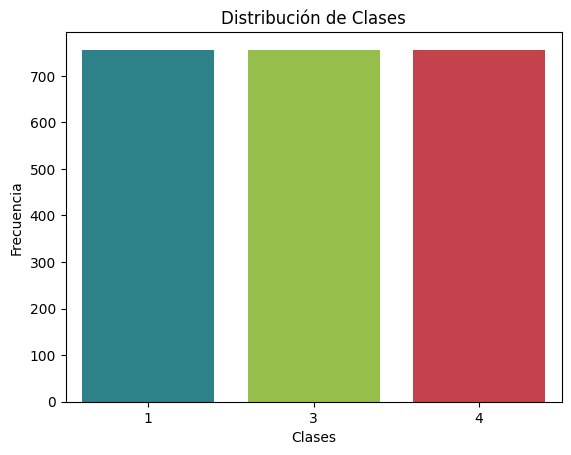

In [30]:
value_counts = df_train_final["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [31]:
X_train_new = df_train_final["textos"]
y_train_new = df_train_final["labels"]
X_val_aug = df_val["textos"]
y_val_aug = df_val["labels"]

vectorizer_aug = CountVectorizer(ngram_range=(1,1))
X_train_aug_vec = vectorizer_aug.fit_transform(X_train_new.fillna(""))
X_val_aug_vec = vectorizer_aug.transform(X_val_aug.fillna(""))

# Entrenamiento
model_aug = LogisticRegression(max_iter=1000, random_state=42)

model_aug.fit(X_train_aug_vec, y_train_new)

y_val_pred_aug = model_aug.predict(X_val_aug_vec)

print("Modelo con aumento:")
print(classification_report(y_val_aug, y_val_pred_aug))

Modelo con aumento:
              precision    recall  f1-score   support

           1       0.94      0.97      0.96       101
           3       0.97      0.96      0.97       195
           4       0.99      0.98      0.99       208

    accuracy                           0.97       504
   macro avg       0.97      0.97      0.97       504
weighted avg       0.97      0.97      0.97       504



In [32]:
df_train_final.to_excel(r"df_retrain/datos_retrain.xlsx", index=False)